In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
LATENT_DIM = 512
BATCH_SIZE = 16
IMAGE_SIZE = 32
EPOCHS = 5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [2]:
def mapping_network(latent_dim, layers=8):
    layers_list = []
    for _ in range(layers):
        layers_list.append(nn.Linear(latent_dim, latent_dim))
        layers_list.append(nn.ReLU())
    return nn.Sequential(*layers_list)


In [3]:
class AdaIN(nn.Module):
    def forward(self, content, style):
        mean = content.mean([2, 3], keepdim=True)
        std = content.std([2, 3], keepdim=True)
        normalized = (content - mean) / (std + 1e-8)
        scale, bias = style
        return scale * normalized + bias


In [4]:
class ProgressiveBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, 3, padding=1)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, padding=1)
        self.upsample = nn.Upsample(scale_factor=2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.upsample(x)
        x = torch.relu(self.conv2(x))
        return x


In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.mapping = mapping_network(LATENT_DIM)
        self.fc = nn.Linear(LATENT_DIM, 128 * 4 * 4)
        self.block1 = ProgressiveBlock(128, 128)
        self.block2 = ProgressiveBlock(128, 64)
        self.block3 = ProgressiveBlock(64, 32)
        self.to_rgb = nn.Conv2d(32, 3, 1)

    def forward(self, z):
        w = self.mapping(z)
        x = self.fc(w).view(-1, 128, 4, 4)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        return torch.sigmoid(self.to_rgb(x))

G = Generator().to(DEVICE)


In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))
        )
        self.classifier = nn.Linear(128 * 4 * 4, 1)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

D = Discriminator().to(DEVICE)


In [7]:
criterion = nn.BCEWithLogitsLoss()
g_opt = optim.Adam(G.parameters(), lr=1e-4)
d_opt = optim.Adam(D.parameters(), lr=1e-4)


In [8]:
for epoch in range(EPOCHS):
    for _ in range(50):
        real = torch.rand(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE).to(DEVICE)
        z = torch.randn(BATCH_SIZE, LATENT_DIM).to(DEVICE)

        fake = G(z)

        d_loss = criterion(D(real), torch.ones(BATCH_SIZE, 1).to(DEVICE)) + \
                 criterion(D(fake.detach()), torch.zeros(BATCH_SIZE, 1).to(DEVICE))

        d_opt.zero_grad()
        d_loss.backward()
        d_opt.step()

        g_loss = criterion(D(fake), torch.ones(BATCH_SIZE, 1).to(DEVICE))
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()

    print(f"Epoch {epoch+1}: G={g_loss.item():.4f}, D={d_loss.item():.4f}")


Epoch 1: G=0.8892, D=1.0970
Epoch 2: G=1.1392, D=0.8143
Epoch 3: G=3.2827, D=0.0613
Epoch 4: G=4.5017, D=0.0176
Epoch 5: G=5.1645, D=0.0089


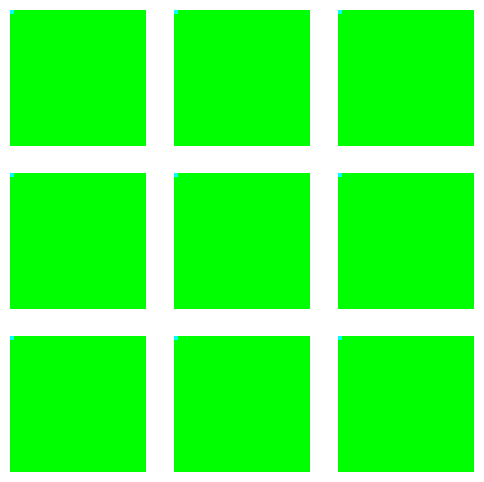

In [9]:
def show_images(images, rows, cols):
    fig, axs = plt.subplots(rows, cols, figsize=(6, 6))
    for i, ax in enumerate(axs.flatten()):
        img = images[i].detach().cpu().permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.axis("off")
    plt.show()

z = torch.randn(9, LATENT_DIM).to(DEVICE)
show_images(G(z), 3, 3)
